<a href="https://colab.research.google.com/github/mostafaramadann/30Days-of-Remontada/blob/main/Day1/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.nn import Module,Conv2d,ReLU,MaxPool2d, ConvTranspose2d,Sigmoid,BatchNorm2d
from torch.optim import Adam
from torchsummary import summary
from torch.utils.data import DataLoader
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
EPOCHS = 30
BATCH_SIZE = 16
DEVICE = "cuda"

In [3]:
import json

!rm -rf /root/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"mostafaramadan","key":"2b145d419d93ac3ce5ccfa0b83a3728d"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip -q lgg-mri-segmentation.zip

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

In [6]:
df = create_df("kaggle_3m")

In [34]:
def normalize(image):
  range = image.max()-image.min()
  if range == 0:
    return image/255.
  return (image-image.min())/range 

class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self,df):
    self.df = df
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    row = df.iloc[idx]
    image = cv2.imread(row[0])
    mask = cv2.imread(row[1])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    
    image = cv2.resize(image,[256,256])
    mask = cv2.resize(mask,[256,256]) 
    
    image = np.transpose(image,(2,0,1))
    mask = np.transpose(np.expand_dims(mask,axis=-1),(2,0,1))
    image, mask = normalize(image).astype("float64"),normalize(mask).astype("float64")
    
    return torch.Tensor(image),torch.Tensor(mask)

In [21]:
train_df,test_df = train_test_split(df,test_size=0.25)
test_df,valid_df = train_test_split(test_df,test_size=0.2)

print(len(train_df),len(test_df),len(valid_df))
train_dataset = SegmentationDataset(train_df)
test_dataset = SegmentationDataset(test_df)
valid_dataset = SegmentationDataset(valid_df)

2946 786 197


In [22]:
def vizualise(image,mask):
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].set_title("Image")
  ax[0].imshow(image,cmap="gray")
  ax[1].set_title("Mask")
  ax[1].imshow(mask,cmap="gray")

(256, 256, 1)


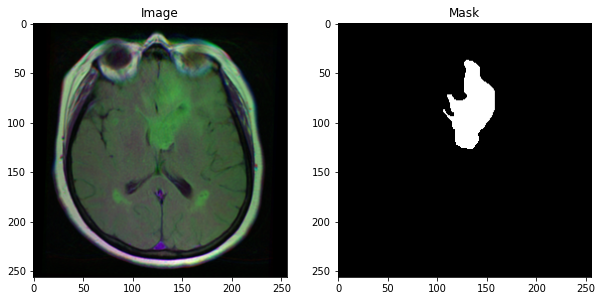

In [23]:
image,mask = train_dataset[49]
image,mask = np.transpose(image.detach().cpu().numpy(),(1,2,0)),np.transpose(mask.detach().cpu().numpy(),(1,2,0))
vizualise(image,mask)
print(mask.shape)


In [24]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [42]:
class ConvBlock(Module):

  def __init__(self,in_channels,out_channels):
    super(ConvBlock,self).__init__()

    self.cv1 = Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),padding="same")
    self.relu1 = ReLU()
    self.bn1 = BatchNorm2d(out_channels)

      
    self.cv2 = Conv2d(in_channels =out_channels ,out_channels=out_channels,kernel_size=(3,3),padding="same")
    self.relu2 = ReLU()
    self.bn2 = BatchNorm2d(out_channels)

  
  def forward(self,x):

    x = self.cv1(x)
    x = self.relu1(x)
    x = self.bn1(x)

    x = self.cv2(x)
    x = self.relu2(x)
    x = self.bn2(x)

    return x

In [51]:
from torch.nn.modules.upsampling import Upsample
class Unet(Module):
  def __init__(self):
    super(Unet,self).__init__()
    self.cbe1 = ConvBlock(3,128)
    self.down1 = MaxPool2d(kernel_size=(2,2),stride=(2,2))

    self.cbe2 = ConvBlock(128,256)
    self.down2 = MaxPool2d(kernel_size=(2,2),stride=(2,2))

    self.cbe3 = ConvBlock(256,512)
    self.down3 = MaxPool2d(kernel_size=(2,2),stride=(2,2))


    self.up1 = ConvTranspose2d(in_channels=512,out_channels=512,kernel_size=(2,2),stride=(2,2))

    self.cbd1 = ConvBlock(1024,512)
    self.up2 = ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(2,2),stride=(2,2))

    self.cbd2 = ConvBlock(512,256)
    self.up3 = ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(2,2),stride=(2,2))

    self.cbd3 = ConvBlock(256,128)

    self.conv1 = Conv2d(in_channels=128,out_channels=64,kernel_size=(1,1),padding="same")
    self.r1 = ReLU()
    self.bn1 = BatchNorm2d(64)
    self.conv2 = Conv2d(in_channels=64,out_channels=32,kernel_size=(1,1),padding="same")
    self.r2 = ReLU()

    self.conv3 = Conv2d(in_channels=32,out_channels=1,kernel_size=(1,1),padding="same")

    self.sig = Sigmoid()

  def forward(self,x):
    ##encoder
    c1 = self.cbe1(x)
    x = self.down1(c1)

    c2 = self.cbe2(x)
    x = self.down2(c2)

    c3 = self.cbe3(x)
    x = self.down3(c3)

    ## decoder
    x = self.up1(x)
    
    x = torch.cat((x,c3),1)
    x = self.cbd1(x)
    x = self.up2(x)

    x = torch.cat((x,c2),1)
    x = self.cbd2(x)
    x = self.up3(x)


    x = torch.cat((x,c1),1)
    x = self.cbd3(x)

    x = self.conv1(x)
    x = self.r1(x)

    x = self.conv2(x)
    x = self.r2(x)

    x = self.conv3(x)
    x = self.sig(x)

    return x


In [52]:
model = Unet()
summary(model.cuda(),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           3,584
              ReLU-2        [-1, 128, 256, 256]               0
       BatchNorm2d-3        [-1, 128, 256, 256]             256
            Conv2d-4        [-1, 128, 256, 256]         147,584
              ReLU-5        [-1, 128, 256, 256]               0
       BatchNorm2d-6        [-1, 128, 256, 256]             256
         ConvBlock-7        [-1, 128, 256, 256]               0
         MaxPool2d-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 256, 128, 128]         295,168
             ReLU-10        [-1, 256, 128, 128]               0
      BatchNorm2d-11        [-1, 256, 128, 128]             512
           Conv2d-12        [-1, 256, 128, 128]         590,080
             ReLU-13        [-1, 256, 128, 128]               0
      BatchNorm2d-14        [-1, 256, 1

  0%|          | 0/185 [00:00<?, ?it/s]


torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
(16, 3, 256, 256) (16, 1, 256, 256)


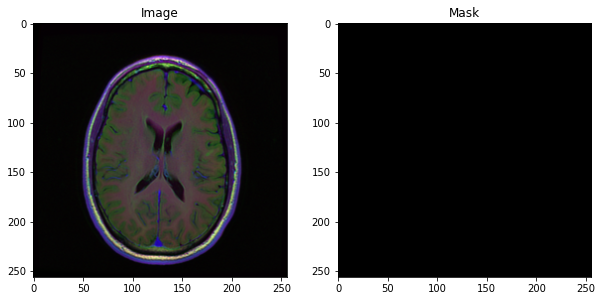

In [53]:
for (x,y) in tqdm(train_loader):
  break
print(x.size(),y.size())
print(y.min(),y.max())
print(x.min(),x.max())
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
print(x.shape,y.shape)
image,mask = np.transpose(x,(0,2,3,1)),np.transpose(y,(0,2,3,1))
vizualise(image[0],mask[0])

In [54]:
def seg_loss(pred,target):
  def dice_loss():
    
    smooth = 1
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
      
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
  
  loss1 = torch.nn.BCEWithLogitsLoss()(pred,target)
  loss2 = dice_loss()
  return loss1+loss2

In [56]:
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = seg_loss

In [57]:
def train_fn(data_loader,model,optimizer,loss_fn):

  model.train()
  total_loss = 0.0
  for (x,y) in tqdm(data_loader):

    x,y = x.to(DEVICE),y.to(DEVICE)
    y_hat = model(x)
    loss = loss_fn(y_hat,y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()

  return total_loss/len(data_loader)

def valid_fn(data_loader,model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      y_hat = model(images)
      loss = loss_fn(y_hat,masks)

      total_loss +=loss.item()
      
  return total_loss/len(data_loader)

In [ ]:
train_loss = []
for i in range(EPOCHS):
  loss = train_fn(train_loader,model,optimizer,loss_fn)
  train_loss.append(loss)
  valid_loss = valid_fn(valid_loader,model)
  print(f"epoch {i} train loss is {loss} , valid loss is {valid_loss}")

100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


epoch 0 train loss is 0.8546399760890652 , valid loss is 0.8688031297463638


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


epoch 1 train loss is 0.8002572275496818 , valid loss is 0.8505065349432138


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


epoch 2 train loss is 0.7832111738823556 , valid loss is 0.8626617055672866


 54%|█████▎    | 99/185 [03:32<03:04,  2.15s/it]

In [ ]:
# class ConvBlock(Module):
#   def __init__(self,filters,upsample=None,last=False):
#     self.last = last
#     super(ConvBlock,self).__init__()
#     self.conv1 = Conv2d(in_channels=filters[0][0],out_channels=filters[0][1],kernel_size=(3,3),padding="same")
#     self.relu1 = ReLU()
#     self.conv2 = Conv2d(in_channels=filters[1][0],out_channels=filters[1][1],kernel_size=(3,3),padding="same")
#     self.relu2= ReLU()
    
#     if upsample:
#       self.llayer = ConvTranspose2d(in_channels=filters[1][1],out_channels=filters[1][1],kernel_size=(2,2),stride=2)
#     else:
#       self.llayer = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

#   def forward(self,x,concat = None):
#     if concat is not None:
#       x = torch.cat((x,concat),1)

#     x = self.conv1(x)
#     x = self.relu1(x)
#     x = self.conv2(x)
#     c = self.relu2(x)
#     if not self.last:
#       x = self.llayer(c)

#     if concat is not None:
#       return x
#     return x,c

In [ ]:
# class Encoder(Module):
#   def __init__(self,filters,in_channels=3):
#     super(Encoder,self).__init__()
#     self.cb1 = ConvBlock(filters[0])
#     self.bn1 = BatchNorm2d(32)
#     self.cb2 = ConvBlock(filters[1])
#     self.bn2 = BatchNorm2d(64)
#     self.cb3 = ConvBlock(filters[2])
#     self.bn3 = BatchNorm2d(128)
#     self.cb4 = ConvBlock(filters[3])
#     self.bn4 = BatchNorm2d(256)
#     self.cb5 = ConvBlock(filters[4])
#     self.bn5 = BatchNorm2d(512)
#     self.cb6 = ConvBlock(filters[5])

#   def forward(self,x):
#     x,c1 = self.cb1(x)
#     x = self.bn1(x)
#     x,c2 = self.cb2(x)
#     x = self.bn2(x)
#     x,c3 = self.cb3(x)
#     x = self.bn3(x)
#     x,c4 = self.cb4(x)
#     x = self.bn4(x)
#     x,c5 = self.cb5(x)
#     x = self.bn5(x)
#     x,c6 = self.cb6(x)

#     return x,c1,c2,c3,c4,c5,c6

In [ ]:
# class Decoder(Module):

#   def __init__(self,filters,in_channels = 256):
#     super(Decoder,self).__init__()
#     self.cb1  = ConvBlock(filters[0],upsample=True)
#     self.bn1 = BatchNorm2d(512)
#     self.cb2  = ConvBlock(filters[1],upsample=True)
#     self.bn2 = BatchNorm2d(256)
#     self.cb3  = ConvBlock(filters[2],upsample=True)
#     self.bn3 = BatchNorm2d(128)
#     self.cb4  = ConvBlock(filters[3],upsample=True)
#     self.bn4 = BatchNorm2d(64)
#     self.cb5  = ConvBlock(filters[4],upsample=True)
#     self.bn5 = BatchNorm2d(32)
#     self.cb6  = ConvBlock(filters[5],upsample=True,last=True)

#   def forward(self,x,c):
#     x = self.cb1(x,c[0])
#     x = self.bn1(x)
#     x = self.cb2(x,c[1])
#     x = self.bn2(x)
#     x = self.cb3(x,c[2])
#     x = self.bn3(x)
#     x = self.cb4(x,c[3])
#     x = self.bn4(x)
#     x = self.cb5(x,c[4])
#     x = self.bn5(x)
#     x = self.cb6(x,c[5])

#     return x

In [ ]:
# class Unet(Module):
#   def __init__(self,filters_enc,filters_dec):

#     super(Unet,self).__init__()
#     self.enc = Encoder(filters_enc)
#     self.upsample = ConvTranspose2d(in_channels=1024,out_channels=1024,kernel_size=(2,2),stride=2)
#     self.dec = Decoder(filters_dec,in_channels=1024)
#     self.conv1 = Conv2d(in_channels=16,out_channels=1,kernel_size=(1,1))
#     self.sig = Sigmoid()

#   def forward(self,x):
#     x,c1,c2,c3,c4,c5,c6 = self.enc(x)
#     x = self.upsample(x)
#     x = self.dec(x,[c6,c5,c4,c3,c2,c1])
#     x = self.conv1(x)
#     x = self.sig(x)
#     return x

In [ ]:
# filters_enc = [
#                 [[3,32], ## cb1
#                 [32,32]],
        
#                 [[32,64],## cb2
#                 [64,64]],
               
#                 [[64,128], ## cb3 
#                  [128,128]], 
               
#                  [[128,256], ## cb4
#                   [256,256]],
               
#                 [[256,512], ## cb5
#                 [512,512]],
                
#                 [[512,1024], ## cb6
#                 [1024,1024]]
            
#                ]

# filters_dec = [
#                 [[2048,1024],#cb1
#                 [1024,512]],
               
#                [[1024,512],#cb2
#                 [512,256]],
               
#                [[512,256],#cb3
#                 [256,128]],
               
#                [[256,128],#cb4
#                 [128,64]],
               
#                 [[128,64],#cb5
#                 [64,32]],
              
#                 [[64,32],#cb6
#                 [32,16]]
               
#                ]
               

# model = Unet(filters_enc,filters_dec)
# summary(model.cuda(),(3,256,256))